In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from fairlearn.metrics import MetricFrame, selection_rate, equalized_odds_ratio, equalized_odds_difference
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the data
X = pd.read_csv("acsincome_ca_features.csv")
y = pd.read_csv("acsincome_ca_labels.csv")
X.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0
1,21.0,4.0,16.0,5.0,1970.0,6.0,17.0,20.0,1.0,1.0
2,65.0,2.0,22.0,5.0,2040.0,6.0,17.0,8.0,1.0,1.0
3,33.0,1.0,14.0,3.0,9610.0,36.0,16.0,40.0,1.0,1.0
4,18.0,2.0,19.0,5.0,1021.0,6.0,17.0,18.0,2.0,1.0


In [3]:
# checking for missing values
print(X.isnull().sum())
print(y.isnull().sum())

AGEP     0
COW      0
SCHL     0
MAR      0
OCCP     0
POBP     0
RELP     0
WKHP     0
SEX      0
RAC1P    0
dtype: int64
PINCP    0
dtype: int64


In [4]:
# shuffle the data, select 10%
X, y = shuffle(X, y, random_state=1)

num_samples = int(len(X)*0.1)
X, y = X[:num_samples], y[:num_samples]

print(X.shape)
print(y.shape)

(19566, 10)
(19566, 1)


In [5]:
# Standrize and split the data
scaler = StandardScaler()
scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [6]:
param_grid_SVC = {
    'C': [0.1, 1, 10, 50, 100],
    'kernel': ['rbf']
}
param_grid_randomF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
param_grid_adaboost = {
    'n_estimators': [50, 100, 200],                   
    'learning_rate': [0.01, 0.1, 1.0, 2.0]
}
param_grid_gradientboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7]
}

models = []
models.append(('SVM', SVR(), param_grid_SVC))
models.append(('RF', RandomForestClassifier(), param_grid_randomF))
models.append(('AB', AdaBoostClassifier(), param_grid_adaboost))
models.append(('GB', GradientBoostingClassifier(), param_grid_gradientboost))

In [7]:
names = []
best_estimators = []
best_hyperparams = []
best_scores = []

for name, model, params in models:
    print( ">> GridSearch of {} in progress ...".format(name))
    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=5)
    grid_search.fit(X_train,y_train)
    names.append(name)
    best_estimators.append(grid_search.best_estimator_)
    best_hyperparams.append(grid_search.best_params_)
    best_scores.append(grid_search.best_score_)

>> GridSearch of SVM in progress ...


In [ ]:
df = pd.DataFrame({
    'Model': names,
    'Best estimator': best_estimators,
    'Best hyperparameters': best_hyperparams,
    'Best score': best_scores
})
display(df)

,Model,Best estimator,Best hyperparameters,Best score
0,SVM,SVR(C=0.1),"{'C': 0.1, 'kernel': 'rbf'}",NaN
1,RF,"(DecisionTreeClassifier(max_depth=10, max_feat...","{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.809865
2,AB,"(DecisionTreeClassifier(max_depth=1, random_st...","{'learning_rate': 1.0, 'n_estimators': 200}",0.814209
3,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.816829


In [ ]:
train_scores = []
train_mean_scores = []
train_std_deviation = []

test_scores = []
test_mean_scores = []
test_std_deviation = []

for model in best_estimators:
    train_result = cross_val_score(model, X_train, y_train, cv=5)
    train_scores.append(train_result)
    train_mean_scores.append(round(train_result.mean(), 2))
    train_std_deviation.append(round(train_result.std(), 3))

    test_result = cross_val_score(model, X_test, y_test, cv=5)
    test_scores.append(test_result)
    test_mean_scores.append(round(test_result.mean(), 2))
    test_std_deviation.append(round(test_result.std(), 3))

data = pd.DataFrame({
    'Model': names,
    'Train mean': train_mean_scores,
    'Train std': train_std_deviation,
    'Test mean': test_mean_scores,
    'Test std': test_std_deviation
})

display(data)

,Model,Train mean,Train std,Test mean,Test std
0,SVM,0.07,0.019,0.07,0.040
1,RF,0.81,0.006,0.80,0.007
2,AB,0.81,0.003,0.80,0.007
3,GB,0.82,0.006,0.81,0.010


<Axes: xlabel='Model'>

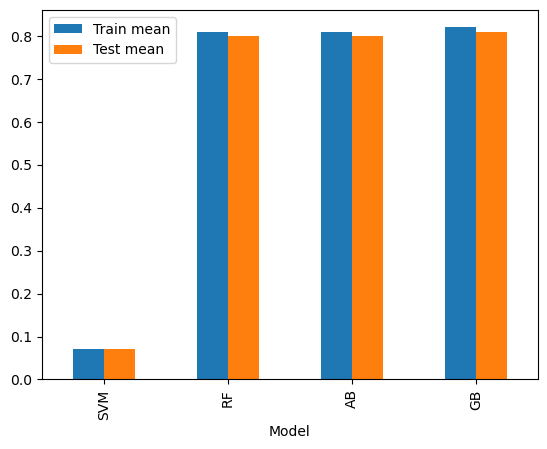

In [ ]:
data.plot(
    x='Model',
    y=['Train mean','Test mean'], 
    kind='bar'
) 

In [ ]:
def plot_confusion_matrix(cm) :
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

>> SVM
Accuracy score :  0.6990291262135923
Classification report :
               precision    recall  f1-score   support

       False       0.70      0.82      0.76      2259
        True       0.69      0.53      0.60      1655

    accuracy                           0.70      3914
   macro avg       0.70      0.68      0.68      3914
weighted avg       0.70      0.70      0.69      3914



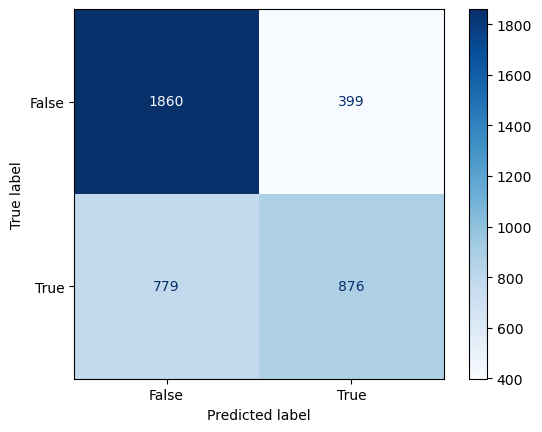

>> RF
Accuracy score :  0.8117015840572305
Classification report :
               precision    recall  f1-score   support

       False       0.83      0.85      0.84      2259
        True       0.79      0.76      0.77      1655

    accuracy                           0.81      3914
   macro avg       0.81      0.80      0.81      3914
weighted avg       0.81      0.81      0.81      3914



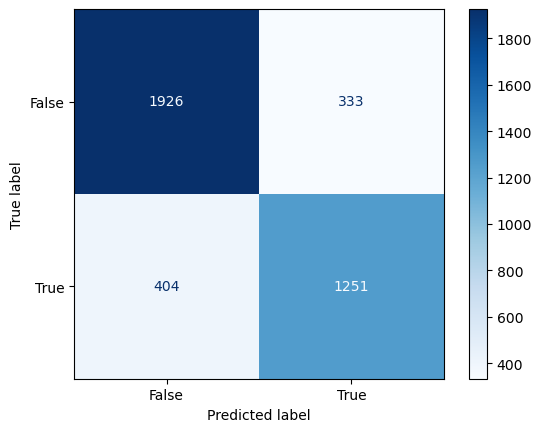

>> AB
Accuracy score :  0.8168114460909556
Classification report :
               precision    recall  f1-score   support

       False       0.83      0.85      0.84      2259
        True       0.79      0.77      0.78      1655

    accuracy                           0.82      3914
   macro avg       0.81      0.81      0.81      3914
weighted avg       0.82      0.82      0.82      3914



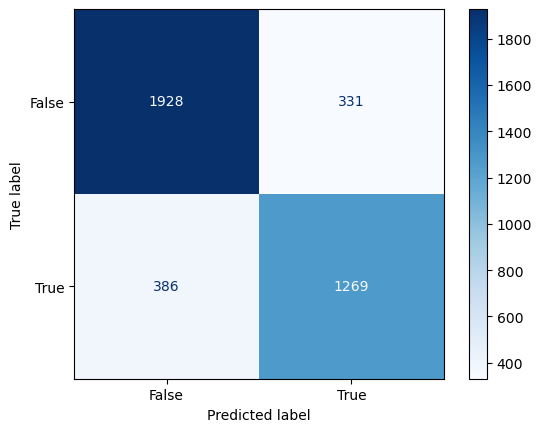

>> GB
Accuracy score :  0.8214103219213081
Classification report :
               precision    recall  f1-score   support

       False       0.84      0.85      0.85      2259
        True       0.79      0.78      0.79      1655

    accuracy                           0.82      3914
   macro avg       0.82      0.82      0.82      3914
weighted avg       0.82      0.82      0.82      3914



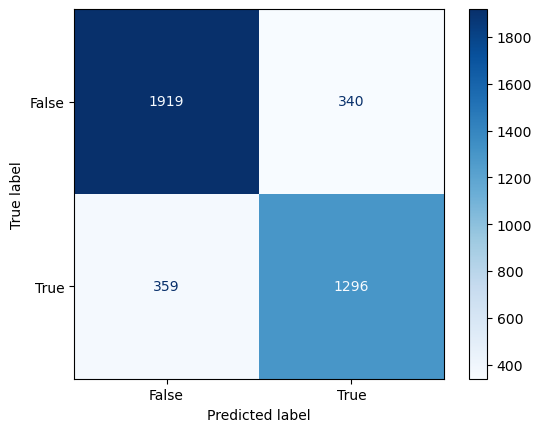

In [ ]:
accuracy_scores = []
y_pred_ca_dataset = []
for index, best_model in enumerate(best_estimators):
    y_pred = best_model.predict(X_test)
    y_pred_ca_dataset.append(y_pred)
    acc_score = accuracy_score(y_test, y_pred.round())
    accuracy_scores.append(acc_score)
    
    print(">> {}".format(names[index]))
    print("Accuracy score : ", acc_score)
    print("Classification report :\n", classification_report(y_test, y_pred.round()))
    plot_confusion_matrix(confusion_matrix(y_test, y_pred.round()))


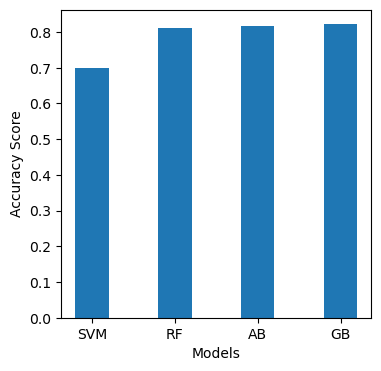

In [ ]:
plt.figure(figsize=(4, 4))
plt.bar(names, accuracy_scores, width=0.4)
plt.xlabel('Models')
plt.ylabel('Accuracy Score')  
plt.show()

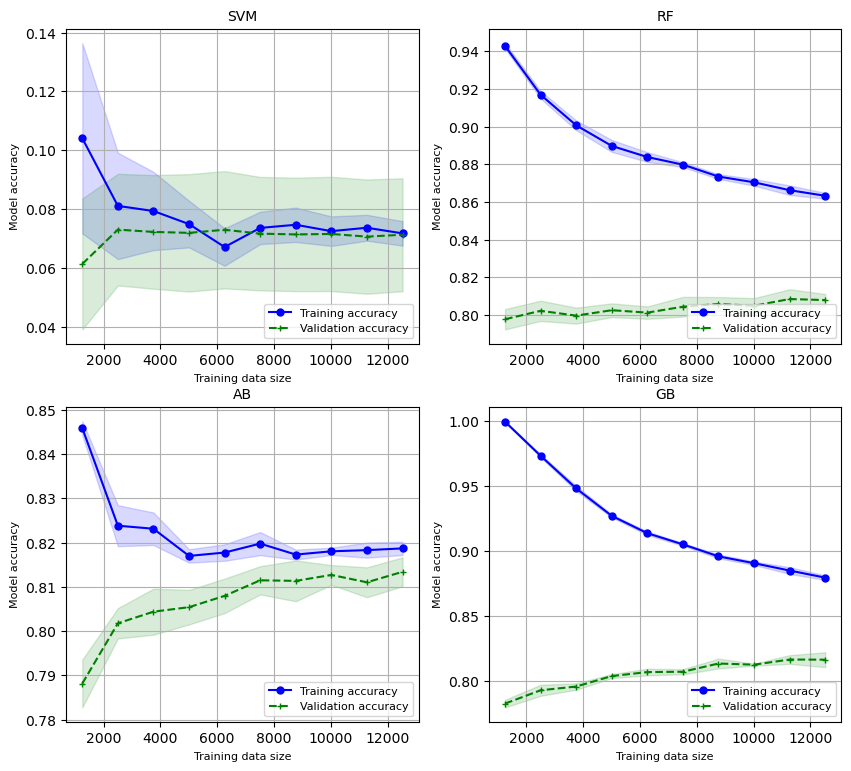

In [ ]:
# Use learning curve to get training and test scores along with train sizes
plt.figure(figsize=(10,9))

for index, model in enumerate(best_estimators):
    plt.subplot(2,2,index+1)
    train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train, 
                                                            cv=5, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(names[index], fontsize=10)
    plt.xlabel('Training data size', fontsize=8)
    plt.ylabel('Model accuracy', fontsize=8)
    plt.grid()
    plt.legend(loc='lower right', fontsize=8)
plt.show()

In [ ]:
# ################################################################################################################## 

In [ ]:
# ############# COLORADO DATASET ###################
X_co = pd.read_csv("acsincome_co_allfeaturesTP2.csv")
y_co = pd.read_csv("acsincome_co_labelTP2.csv")

# checking for missing values
print(X_co.isnull().sum())
print(y_co.isnull().sum())

# shuffle the data, select 10%
X_co, y_co = shuffle(X_co, y_co, random_state=1)
num_samples_ = int(len(X_co)*0.1)
X_co, y_co = X_co[:num_samples], y_co[:num_samples]

# Standrize the data
scaler_co = StandardScaler()
scaler_co.fit_transform(X_co)

X_co.head()

AGEP     0
COW      0
SCHL     0
MAR      0
OCCP     0
POBP     0
RELP     0
WKHP     0
SEX      0
RAC1P    0
dtype: int64
PINCP    0
dtype: int64


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
12591,40.0,1.0,18.0,1.0,110.0,18.0,1.0,40.0,1.0,1.0
1463,21.0,1.0,19.0,1.0,3930.0,8.0,0.0,20.0,2.0,1.0
9624,53.0,3.0,21.0,1.0,2545.0,8.0,0.0,25.0,2.0,1.0
19904,28.0,1.0,21.0,5.0,1305.0,8.0,0.0,45.0,2.0,1.0
5504,17.0,1.0,14.0,5.0,5240.0,8.0,3.0,24.0,2.0,1.0


>> COLORADO DATASET
>> SVM
Accuracy score :  0.6748952264131657
Classification report :
               precision    recall  f1-score   support

           0       0.70      0.77      0.74     11480
           1       0.62      0.54      0.58      8086

    accuracy                           0.67     19566
   macro avg       0.66      0.65      0.66     19566
weighted avg       0.67      0.67      0.67     19566



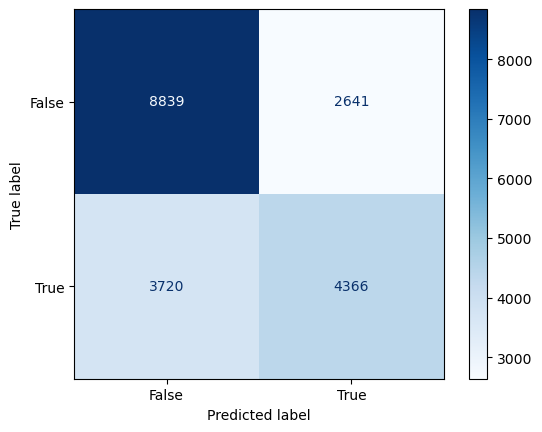

>> RF
Accuracy score :  0.7708269446999898
Classification report :
               precision    recall  f1-score   support

           0       0.85      0.74      0.79     11480
           1       0.69      0.82      0.75      8086

    accuracy                           0.77     19566
   macro avg       0.77      0.78      0.77     19566
weighted avg       0.78      0.77      0.77     19566



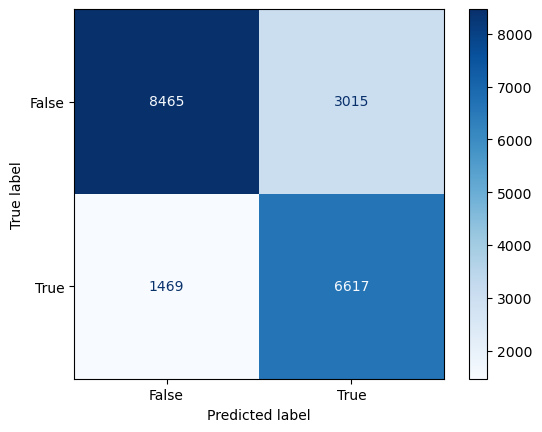

>> AB
Accuracy score :  0.7733312889706634
Classification report :
               precision    recall  f1-score   support

           0       0.87      0.72      0.79     11480
           1       0.68      0.85      0.76      8086

    accuracy                           0.77     19566
   macro avg       0.78      0.78      0.77     19566
weighted avg       0.79      0.77      0.78     19566



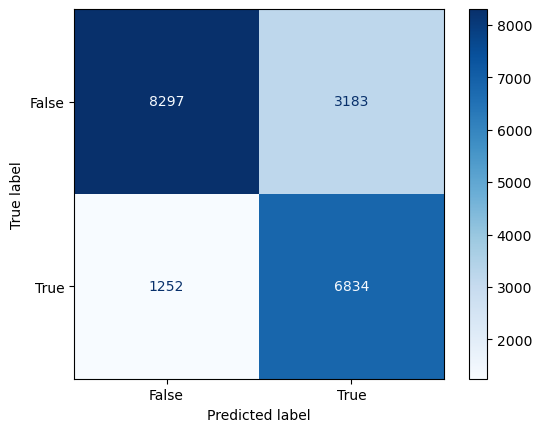

>> GB
Accuracy score :  0.7780844321782684
Classification report :
               precision    recall  f1-score   support

           0       0.86      0.74      0.80     11480
           1       0.69      0.84      0.76      8086

    accuracy                           0.78     19566
   macro avg       0.78      0.79      0.78     19566
weighted avg       0.79      0.78      0.78     19566



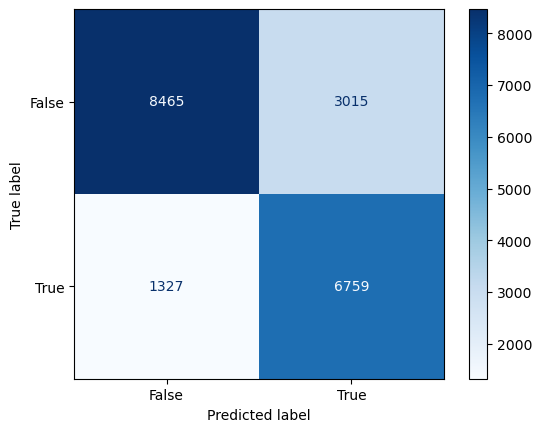

In [ ]:
print(">> COLORADO DATASET")
accuracy_scores_co = []

for index, best_model in enumerate(best_estimators):
    y_pred = best_model.predict(X_co)
    acc_score = accuracy_score(y_co, y_pred.round())
    accuracy_scores_co.append(acc_score)
    
    print(">> {}".format(names[index]))
    print("Accuracy score : ", acc_score)
    print("Classification report :\n", classification_report(y_co, y_pred.round()))
    plot_confusion_matrix(confusion_matrix(y_co, y_pred.round()))

In [ ]:
# ############# NEVADA DATASET ###################
X_ne = pd.read_csv("acsincome_ne_allfeaturesTP2.csv")
y_ne = pd.read_csv("acsincome_ne_labelTP2.csv")

# checking for missing values
print(X_ne.isnull().sum())
print(y_ne.isnull().sum())

# shuffle the data, select 10%
X_ne, y_ne = shuffle(X_ne, y_ne, random_state=1)
num_samples_ = int(len(X_ne)*0.1)
X_ne, y_ne = X_ne[:num_samples], y_ne[:num_samples]

# Standrize the data
scaler_ne = StandardScaler()
scaler_ne.fit_transform(X_ne)

X_ne.head()

AGEP     0
COW      0
SCHL     0
MAR      0
OCCP     0
POBP     0
RELP     0
WKHP     0
SEX      0
RAC1P    0
dtype: int64
PINCP    0
dtype: int64


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
5051,57.0,1.0,16.0,1.0,7810.0,303.0,0.0,40.0,1.0,1.0
9180,39.0,1.0,21.0,1.0,4600.0,19.0,0.0,35.0,2.0,1.0
5547,59.0,1.0,20.0,1.0,2300.0,19.0,0.0,40.0,2.0,1.0
9040,47.0,3.0,16.0,3.0,9620.0,31.0,0.0,35.0,1.0,1.0
6025,36.0,4.0,18.0,5.0,3802.0,31.0,15.0,50.0,1.0,1.0


>> NEVADA DATASET
>> SVM
Accuracy score :  0.6989337042188224
Classification report :
               precision    recall  f1-score   support

           0       0.77      0.81      0.79      7417
           1       0.52      0.46      0.49      3368

    accuracy                           0.70     10785
   macro avg       0.64      0.63      0.64     10785
weighted avg       0.69      0.70      0.69     10785



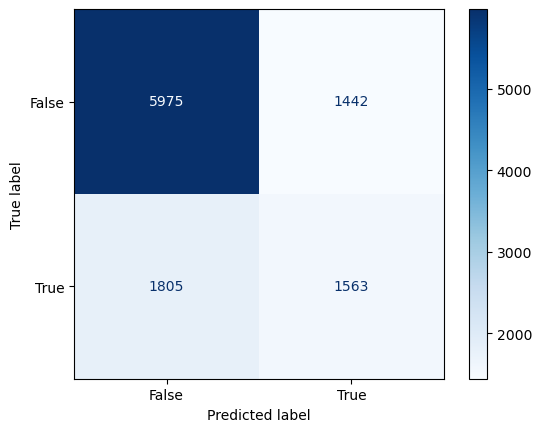

>> RF
Accuracy score :  0.7391747797867408
Classification report :
               precision    recall  f1-score   support

           0       0.90      0.70      0.79      7417
           1       0.56      0.82      0.66      3368

    accuracy                           0.74     10785
   macro avg       0.73      0.76      0.73     10785
weighted avg       0.79      0.74      0.75     10785



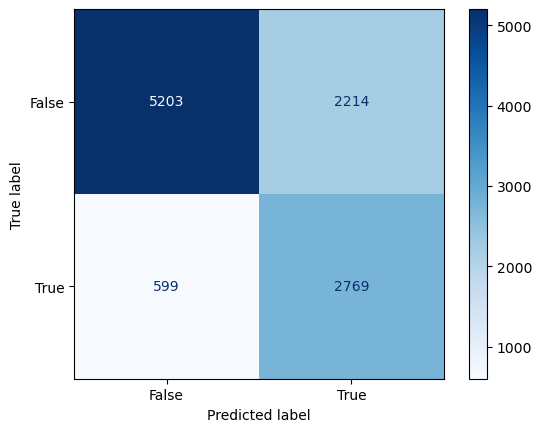

>> AB
Accuracy score :  0.7366713027352805
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.69      0.78      7417
           1       0.55      0.85      0.67      3368

    accuracy                           0.74     10785
   macro avg       0.73      0.77      0.73     10785
weighted avg       0.80      0.74      0.75     10785



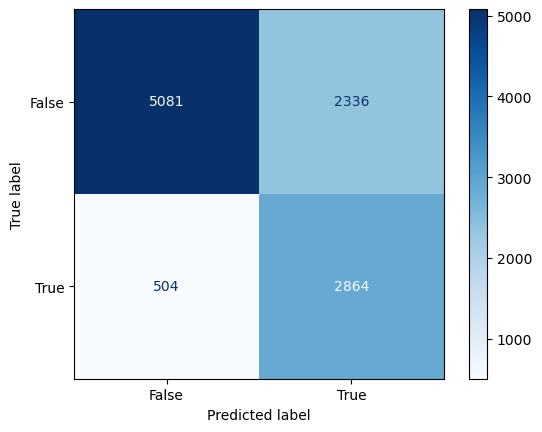

>> GB
Accuracy score :  0.7426054705609643
Classification report :
               precision    recall  f1-score   support

           0       0.90      0.70      0.79      7417
           1       0.56      0.83      0.67      3368

    accuracy                           0.74     10785
   macro avg       0.73      0.77      0.73     10785
weighted avg       0.79      0.74      0.75     10785



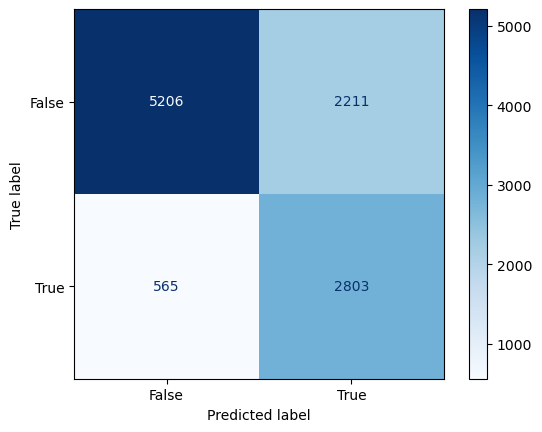

In [ ]:
print(">> NEVADA DATASET")
accuracy_scores_ne = []

for index, best_model in enumerate(best_estimators):
    y_pred = best_model.predict(X_ne)
    acc_score = accuracy_score(y_ne, y_pred.round())
    accuracy_scores_ne.append(acc_score)
    
    print(">> {}".format(names[index]))
    print("Accuracy score : ", acc_score)
    print("Classification report :\n", classification_report(y_ne, y_pred.round()))
    plot_confusion_matrix(confusion_matrix(y_ne, y_pred.round()))

,Model,Californir,Colorado,Nevada
0,SVM,0.699029,0.674895,0.698934
1,RF,0.811702,0.770827,0.739175
2,AB,0.816811,0.773331,0.736671
3,GB,0.821410,0.778084,0.742605


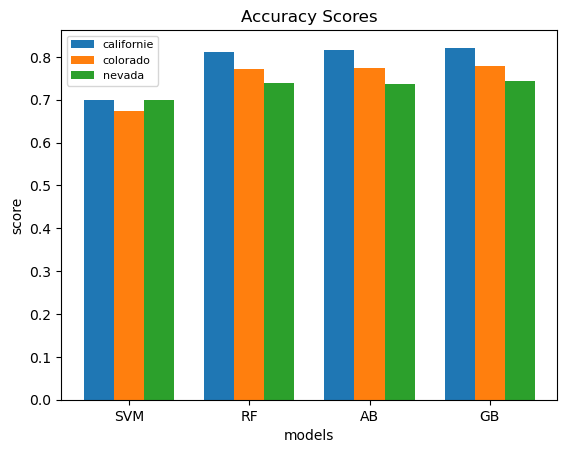

In [ ]:
data = pd.DataFrame({
    'Model': names,
    'Californir': accuracy_scores,
    'Colorado': accuracy_scores_co,
    'Nevada': accuracy_scores_ne
})

display(data)

ind = np.arange(4)  
width = 0.25
  
bar1 = plt.bar(ind, accuracy_scores, width) 
bar2 = plt.bar(ind+width, accuracy_scores_co, width) 
bar3 = plt.bar(ind+width*2, accuracy_scores_ne, width) 
  
plt.xlabel("models") 
plt.ylabel("score") 
plt.title("Accuracy Scores") 
  
plt.xticks(ind+width, names, rotation=0) 
plt.legend((bar1, bar2, bar3), ('californie', 'colorado', 'nevada'), fontsize="8")
plt.show()

In [ ]:
######################################## Part : 2 ##################################################

###### 1 : Explicabilité ###########################################
###### a : 
from sklearn.inspection import permutation_importance


xtrain = pd.DataFrame(X_train)
ytrain = pd.DataFrame(y_train)
training_dataset = pd.concat([xtrain, ytrain], axis=1)
correlations = training_dataset.corr()['PINCP'].drop('PINCP')
print(correlations)

###### d : à voir dans le rapport ####################
    







AGEP     0.264865
COW      0.063485
SCHL     0.337183
MAR     -0.281001
OCCP    -0.337809
POBP    -0.093007
RELP    -0.225464
WKHP     0.338153
SEX     -0.114556
RAC1P   -0.102512
Name: PINCP, dtype: float64


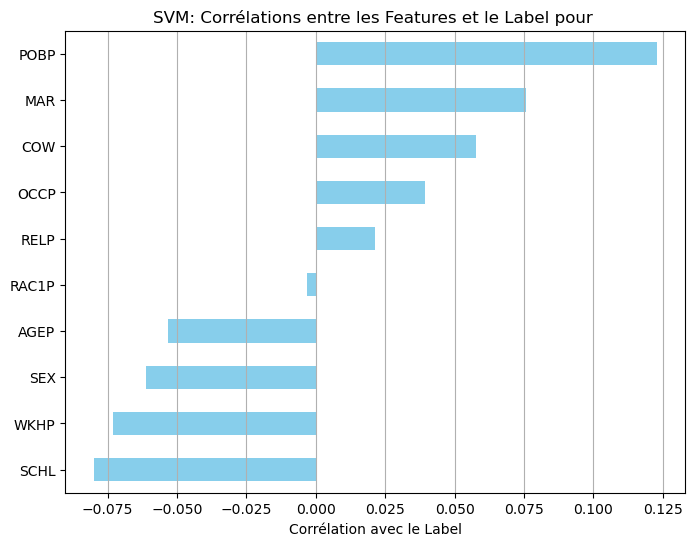

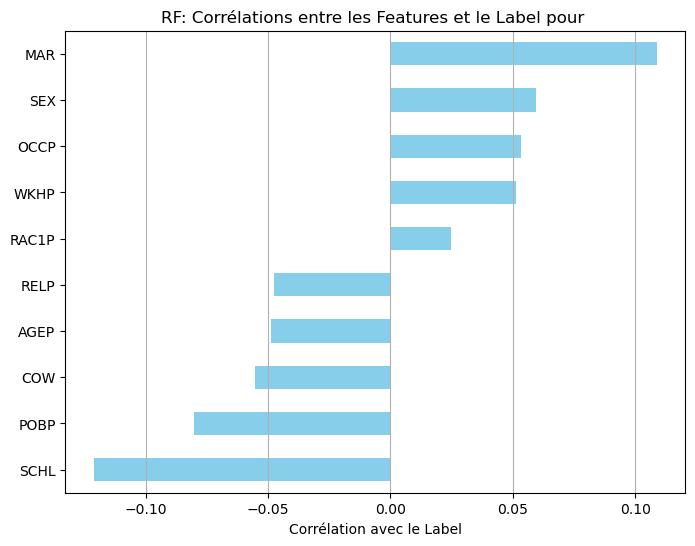

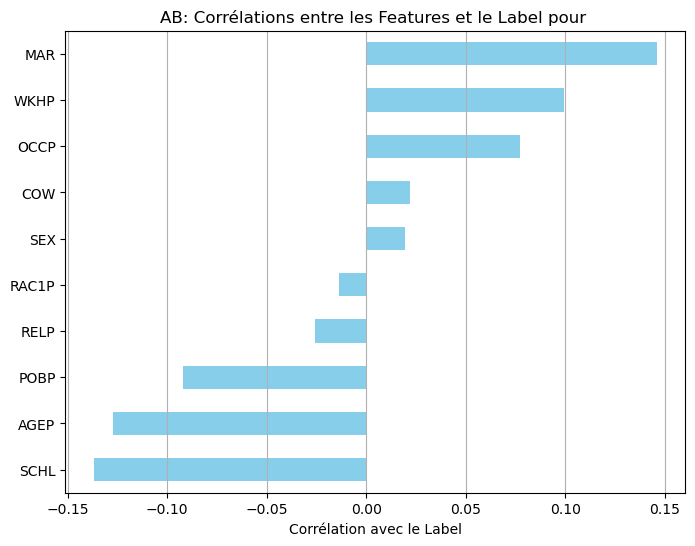

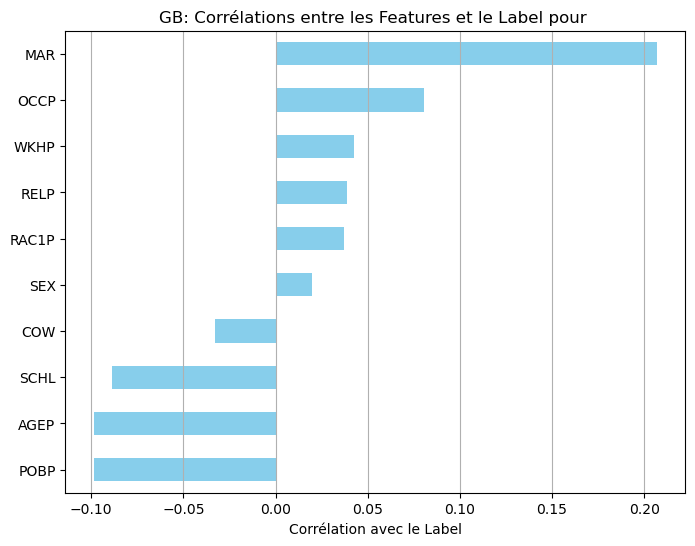

In [ ]:
###### b :
names = ["SVM","RF","AB","GB"]
correlations = []
for predLables in y_pred_ca_dataset:    
    xtest = pd.DataFrame(X_test)
    ypred = pd.DataFrame({'PINCP' : predLables})
    correlations.append(pd.concat([xtest, ypred], axis=1).corr()['PINCP'].drop('PINCP'))

for index, corr in enumerate(correlations):
    plt.figure(figsize=(8, 6))
    corr.sort_values().plot(kind='barh', color='skyblue')
    plt.xlabel('Corrélation avec le Label')
    plt.title(names[index] +": Corrélations entre les Features et le Label pour ")
    plt.grid(axis='x')
    plt.show()
# il faut ajouter la comparaison entre ces corrélations et les corrélations de la question a
    

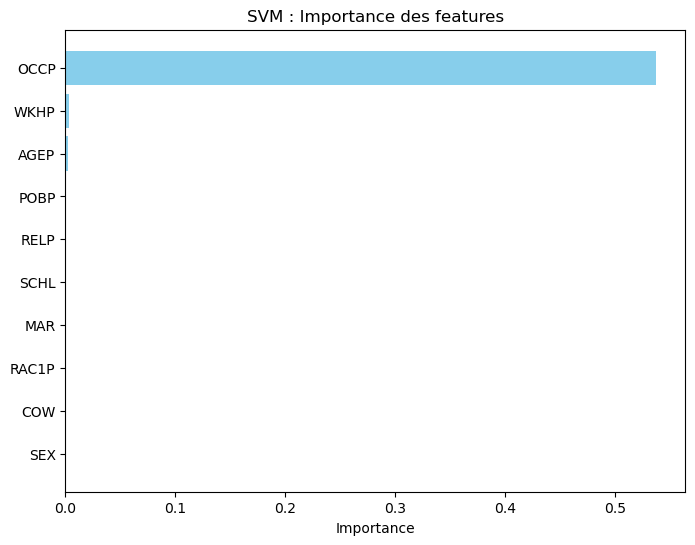

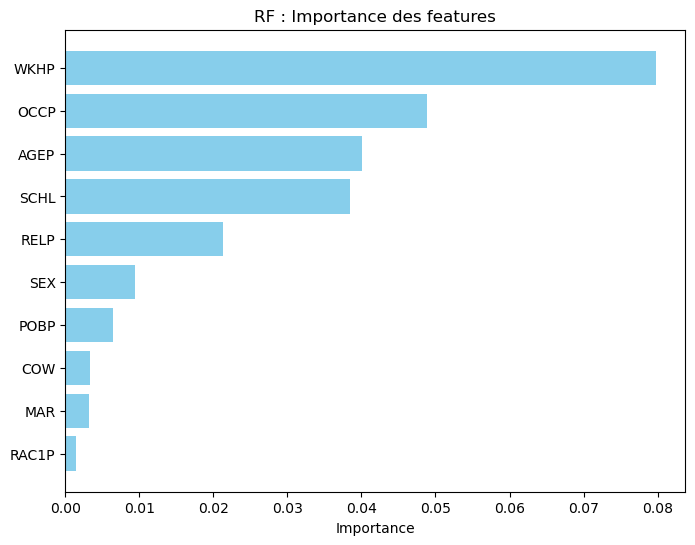

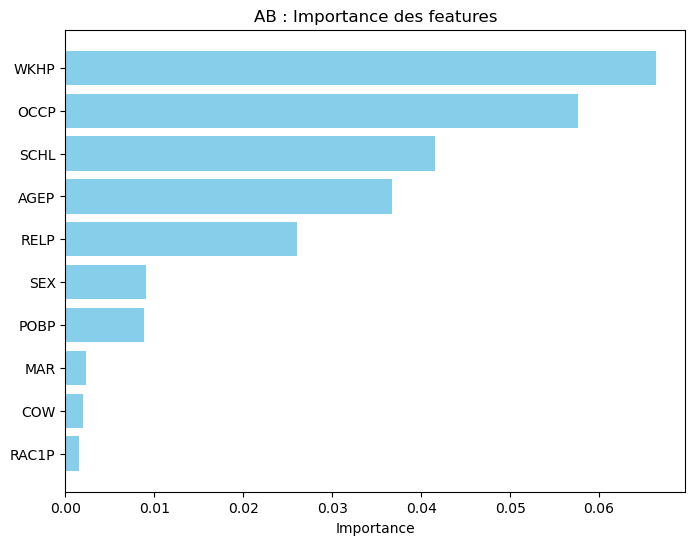

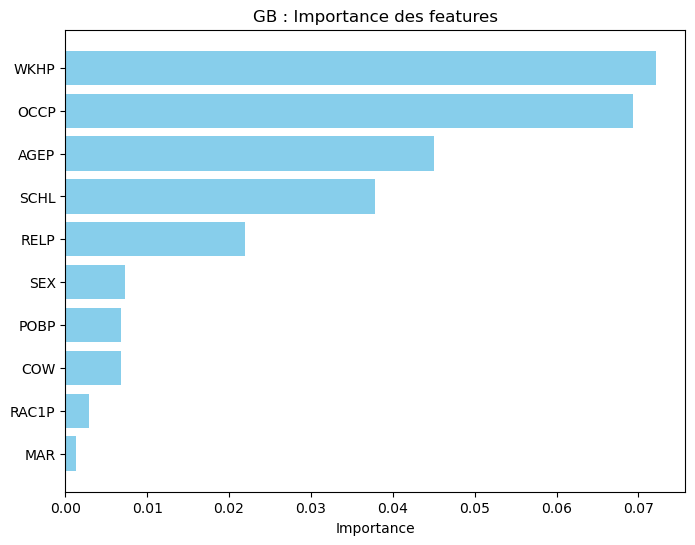

In [ ]:
###### c :
# On récupère l'importance des features pour chaque modèle et on les plot(pour chaque modèle)
for index, model in enumerate(best_estimators):
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    importance = result.importances_mean
    feature_names = X_test.columns
    # Affichage des importances des features dans un graphique
    plt.figure(figsize=(8, 6))
    sorted_idx = importance.argsort()
    plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center', color='skyblue')
    plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])  # Utilisation des vrais noms de features
    plt.xlabel('Importance')
    plt.title(names[index] +" : Importance des features")
    plt.show()

In [ ]:
###### d : à voir dans le rapport ####################

m  5691   5691
f  5094   5094
>> SVM
la matrice de confusion pour les hommes


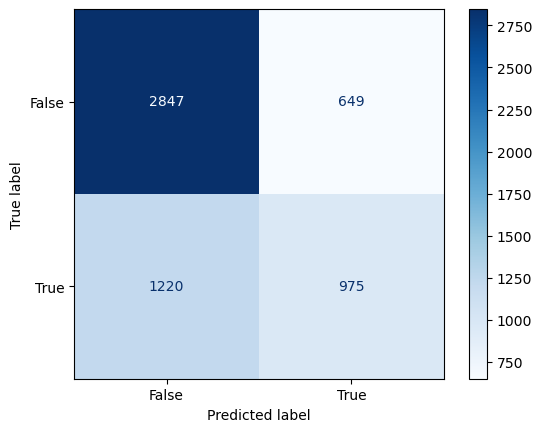

la matrice de confusion pour les femmes


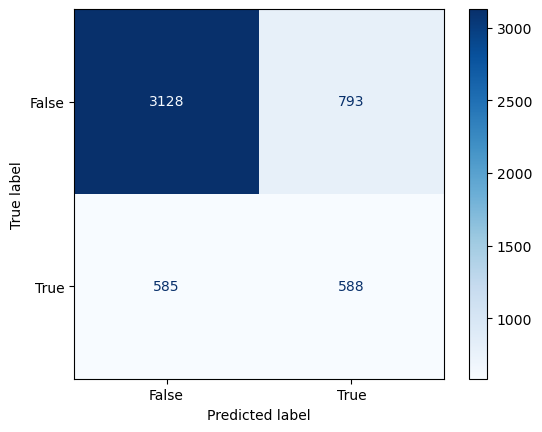

>> RF
la matrice de confusion pour les hommes


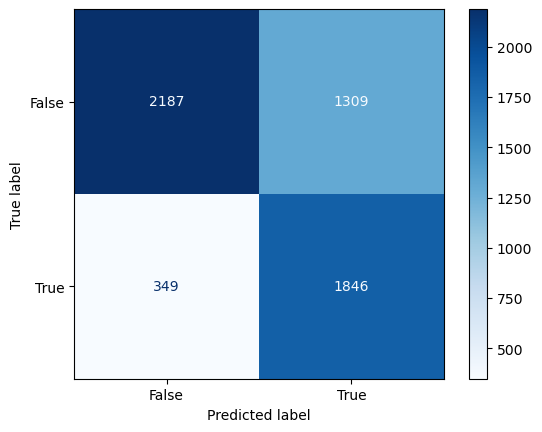

la matrice de confusion pour les femmes


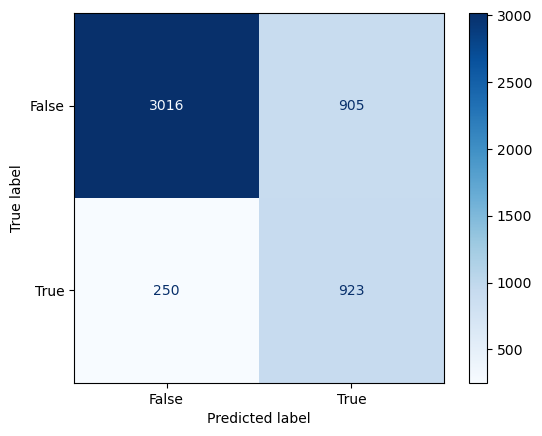

>> AB
la matrice de confusion pour les hommes


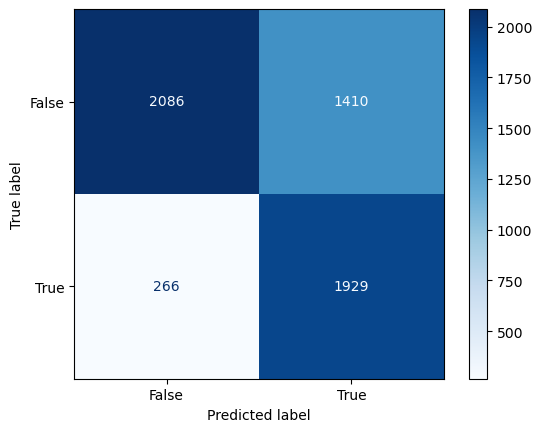

la matrice de confusion pour les femmes


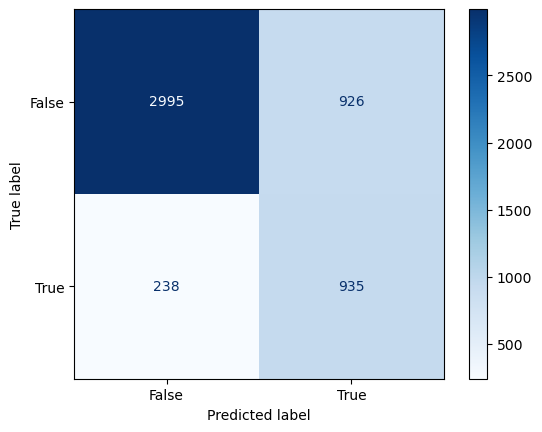

>> GB
la matrice de confusion pour les hommes


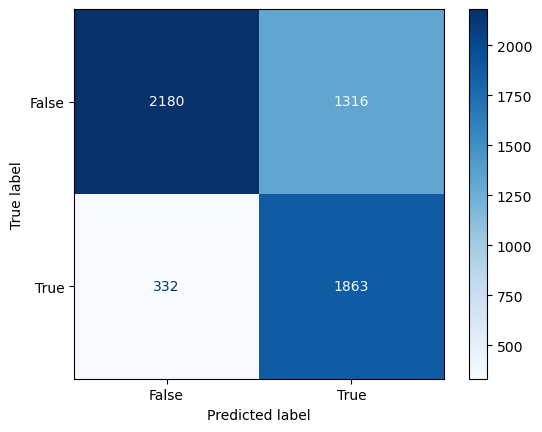

la matrice de confusion pour les femmes


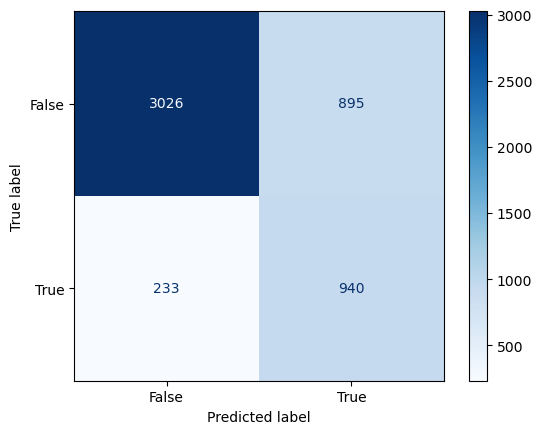

In [ ]:
###### 2 : Equité des modèles ###########################################
###### a :
###### diviser le dataset en deux groupes par apport au SEX(male group et female group)
dataset = pd.concat([X_ne, y_ne], axis=1)

male_group_dataset = dataset[dataset['SEX'] == 1.0]
female_group_dataset = dataset[dataset['SEX'] == 2.0]

y_ne_male = male_group_dataset[['PINCP']].copy()
y_ne_female = female_group_dataset[['PINCP']].copy()

X_ne_male = male_group_dataset.drop('PINCP', axis=1)
X_ne_female = female_group_dataset.drop('PINCP', axis=1)

print("m ",len(X_ne_male)," ",len(y_ne_male))
print("f ",len(X_ne_female)," ",len(y_ne_female))

for index, best_model in enumerate(best_estimators):
    print(">> {}".format(names[index]))
    print("la matrice de confusion pour les hommes")
    y_pred_male = best_model.predict(X_ne_male)
    plot_confusion_matrix(confusion_matrix(y_ne_male, y_pred_male.round()))
    print("la matrice de confusion pour les femmes")
    y_pred_female = best_model.predict(X_ne_female)
    plot_confusion_matrix(confusion_matrix(y_ne_female, y_pred_female.round()))


In [ ]:
####### b: 
####### On va utiliser la métrique "Partitionner en fonction d'attributs sensibles" et la métrique "Métrique parité statistique" \
####### comme métriques d’équité statistique
####### Pour cela, on va utiliser la bibliothèque fairlearn de python (pour l'installer : pip install fairlean)


# Calculer la métrique 'accuracy_score' partitionnée en fonction de la caractéristique sensible
for index, best_model in enumerate(best_estimators):
    print(">> {}".format(names[index]))
    # Pour le training
    y_pred_train = best_model.predict(X_train)
    metric_frame = MetricFrame(selection_rate, y_train, y_pred_train, sensitive_features=X_train['SEX'])
    partitioning_metric1 = metric_frame.overall
    print("Partitioning Metric (Overall):", partitioning_metric1)
    
    # Pour le test
    y_pred_test = best_model.predict(X_test)
    metric_frame = MetricFrame(selection_rate, y_test, y_pred_test, sensitive_features=X_test['SEX'])
    partitioning_metric2 = metric_frame.overall
    print("Partitioning Metric (Overall):", partitioning_metric2)

    # Calculer la métrique de parité statistique
    # Pour le training
    #y_pred_train = best_model.predict(X_train)
    #metric_parity = equalized_odds_difference(y_train, y_pred_train, sensitive_features = X_train['SEX'])
    #print("Métrique Parité Statistique pour le training :", metric_parity)

    # Pour le test
    #y_pred_test = best_model.predict(X_test)
    #metric_frame = equalized_odds_difference(y_test, y_pred_test, sensitive_features = X_test['SEX'])
    #print("Métrique Parité Statistique pour le test :", metric_parity)
    

NameError: name 'best_estimators' is not defined